# Data description & Problem statement: 
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The type of dataset and problem is a classic supervised binary classification. Given a number of elements all with certain characteristics (features), we want to build a machine learning model to identify people affected by type 2 diabetes.


# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training and test part for the final evaluation of model)
   #  Model Training:
- Train an ensemble of Deep Neural Network models by Keras/Tensorflow, and finally aggregate the results (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the Neural Network model on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision

In [1]:
import sklearn, keras
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/pima-indian-diabetes/indians-diabetes.csv') 

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.columns=['NP', 'GC', 'BP', 'ST', 'I',  'BMI', 'PF', 'Age', 'Class']

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
NP       768 non-null int64
GC       768 non-null int64
BP       768 non-null int64
ST       768 non-null int64
I        768 non-null int64
BMI      768 non-null float64
PF       768 non-null float64
Age      768 non-null int64
Class    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df['ST'].replace(0, df[df['ST']!=0]['ST'].mean(), inplace=True)
df['GC'].replace(0, df[df['GC']!=0]['GC'].mean(), inplace=True)
df['BP'].replace(0, df[df['BP']!=0]['BP'].mean(), inplace=True)
df['BMI'].replace(0, df[df['BMI']!=0]['BMI'].mean(), inplace=True)
df['I'].replace(0, df[df['I']!=0]['I'].mean(), inplace=True)

In [5]:
X=df.drop('Class', axis=1)
y=df['Class']

from keras.utils import to_categorical
y=to_categorical(y)

In [6]:
# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scalor_X=MinMaxScaler().fit(X)
X_train=scalor_X.transform(X_train)
X_test=scalor_X.transform(X_test)

In [7]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score

class EarlyStopByAUC(keras.callbacks.Callback):
    def __init__(self, value = 0, verbose = 0):
        super(keras.callbacks.Callback, self).__init__()
        self.value = value
        self.verbose = verbose


    def on_epoch_end(self, epoch, logs={}):
        #score = f1_score(np.argmax(self.validation_data[1], axis=1), np.argmax(model.predict(self.validation_data[0]), axis=1))
        score=roc_auc_score(self.validation_data[1], model.predict_proba(self.validation_data[0]))
        auc_i.append(score)
        
        if score >= self.value:
            if self.verbose >0:
                print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True

In [75]:
# KNN with Cross-Validation:
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_sample_weight

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

sw=compute_sample_weight(class_weight='balanced', y=y_train)
    
model = Sequential()
model.add(Dense(60, input_dim=X.shape[1], activation='relu', kernel_initializer = 'glorot_uniform', 
                                                                activity_regularizer=l2(0.0005))) # Hidden 1
model.add(Dropout(0.2))
    
model.add(Dense(80, activation='relu', kernel_initializer = 'glorot_uniform', 
                                                          activity_regularizer=l2(0.0005))) # Hidden 2
model.add(Dropout(0.3))

model.add(Dense(y_train.shape[1], activation='softmax', kernel_initializer='glorot_uniform')) # Output

auc_i=[]
    
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopByAUC(value =0.9, verbose =1)
#monitor=EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[monitor, checkpointer], verbose=0, class_weight=sw)
model.load_weights('best_weights.hdf5')

# Measure this fold's accuracy
auc_test=roc_auc_score(y_test, model.predict_proba(X_test))
auc_train=roc_auc_score(y_train, model.predict_proba(X_train))

print('Training auc score: ', auc_train, "\n")
print('Validation auc score: ', auc_test)

Training auc score:  0.8829218034725392 

Validation auc score:  0.8345270890725436


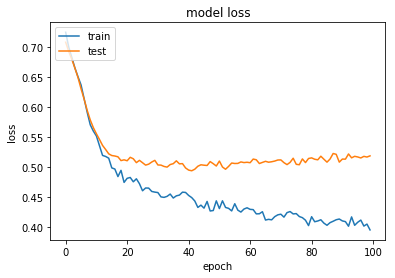

In [76]:
# list all data in history
#print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(0.5,0,'epoch')

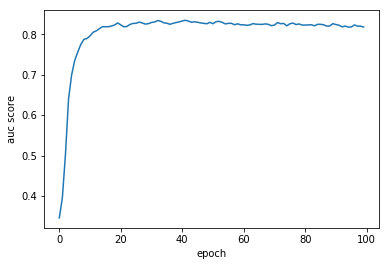

In [77]:
plt.plot(auc_i)

plt.ylabel('auc score')
plt.xlabel('epoch')

Confusion matrix, without normalization
[[83 16]
 [17 38]]
Normalized confusion matrix
[[0.84 0.16]
 [0.31 0.69]]


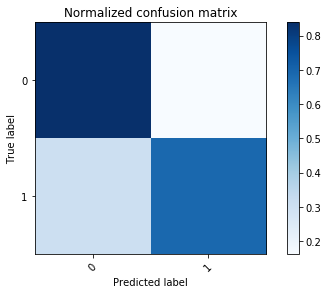

In [78]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [79]:
# Classification report:
report=classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print(report)

             precision    recall  f1-score   support

          0       0.83      0.84      0.83        99
          1       0.70      0.69      0.70        55

avg / total       0.78      0.79      0.79       154



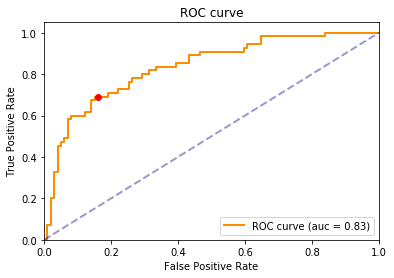

In [80]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test[:, 1]), model.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), model.predict_proba(X_test))

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

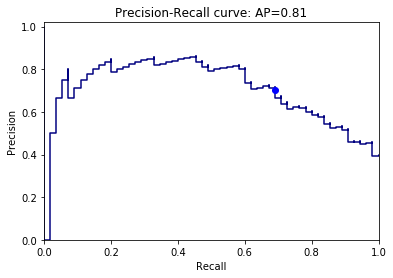

In [81]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test[:, 1], model.predict_proba(X_test)[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test, model.predict_proba(X_test))

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()